# Knowledge Graph Embedding

This notebook demonstrates how to create and evaluate knowledge graph embeddings from the knowledge graph constructed in the previous step. It includes:

1. Data augmentation to address limited entity count
2. Knowledge graph embedding training
3. Evaluation and visualization of embeddings
4. Link prediction

## Setup

First, let's set up the environment and import the necessary libraries.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import standard libraries
import os
import sys
import json
import logging
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [3]:
# Add project root to path for importing local modules
# Adjust this path if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project modules
from src.knowledge_graph.augmentation import KnowledgeGraphAugmenter, augment_knowledge_graph
from src.knowledge_graph.embeddings import KnowledgeGraphEmbedder, create_and_train_embeddings

# Create output directories
os.makedirs('output/data', exist_ok=True)
os.makedirs('output/models', exist_ok=True)
os.makedirs('output/embeddings', exist_ok=True)
os.makedirs('output/visualization', exist_ok=True)

2025-03-29 17:44:42,157 - pykeen.utils - INFO - Using opt_einsum


## 1. Load and Examine the Original Knowledge Graph

First, let's load the knowledge graph we constructed in the previous step and examine its properties.

In [4]:
from rdflib import Graph

# Path to the original knowledge graph
# Adjust this path to match your file
original_kg_path = './output/data/knowledge_graph.ttl'

# Load the graph
original_graph = Graph()
original_graph.parse(original_kg_path, format='turtle')

print(f"Loaded knowledge graph with {len(original_graph)} triples")

# Count entities by type
from rdflib.namespace import RDF

entity_types = {}
for s, p, o in original_graph.triples((None, RDF.type, None)):
    entity_type = str(o).split('/')[-1]
    if entity_type not in entity_types:
        entity_types[entity_type] = 0
    entity_types[entity_type] += 1

print("\nEntity types and counts:")
for entity_type, count in entity_types.items():
    print(f"- {entity_type}: {count}")

# Count relations
relations = {}
for s, p, o in original_graph:
    if p != RDF.type:
        relation = str(p).split('/')[-1]
        if relation not in relations:
            relations[relation] = 0
        relations[relation] += 1

print(f"\nNumber of distinct relations: {len(relations)}")
print("Top 10 most common relations:")
for relation, count in sorted(relations.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"- {relation}: {count}")

Loaded knowledge graph with 6625 triples

Entity types and counts:
- CARDINAL: 408
- DATE: 473
- EVENT: 3
- FAC: 12
- GPE: 300
- LANGUAGE: 1
- LAW: 11
- LOC: 22
- MISC: 148
- MONEY: 115
- NORP: 71
- ORDINAL: 5
- ORG: 962
- PERCENT: 7
- PERSON: 498
- PRODUCT: 28
- QUANTITY: 10
- TIME: 19
- WORK_OF_ART: 11

Number of distinct relations: 124
Top 10 most common relations:
- rdf-schema#label: 3296
- related_to: 58
- say_on: 21
- tell: 5
- report_on: 5
- announce_on: 4
- found_in: 4
- decline: 3
- impose_from: 2
- take_on: 2


## 2. Data Augmentation

To address the challenge of limited entity count, we'll augment our knowledge graph with external knowledge from DBpedia and Wikidata.

In [5]:
# Path for the augmented knowledge graph
augmented_kg_path = './output/data/knowledge_graph_augmented.ttl'

# Create an augmenter
augmenter = KnowledgeGraphAugmenter(namespace="http://example.org/graphify/")

# Load the original knowledge graph
augmenter.load_graph(original_kg_path)

# Extract entities
entities = augmenter.extract_entities()
print(f"Extracted {len(entities)} entities from the knowledge graph")

# For demonstration, we'll enrich a subset of entities
# In a real scenario, you might want to enrich all entities
import random
random.seed(42)  # For reproducibility

# Select persons and organizations preferentially
persons = [e for e in entities if e[1] == 'PERSON']
organizations = [e for e in entities if e[1] == 'ORG']
locations = [e for e in entities if e[1] == 'LOC']
gpes = [e for e in entities if e[1] == 'GPE']

# Determine how many of each to select
max_entities = 10000
person_count = min(len(persons), max_entities // 4)
location_count = min(len(locations), max_entities // 4)
gpe_count = min(len(gpes), max_entities // 4)
org_count = min(len(organizations), max_entities - person_count - location_count - gpe_count)

# Select the entities
selected_persons = random.sample(persons, person_count) if person_count > 0 else []
selected_locs = random.sample(locations, location_count) if location_count> 0 else []
selected_gpes = random.sample(gpes, gpe_count) if gpe_count > 0 else []
selected_orgs = random.sample(organizations, org_count) if org_count > 0 else []

# Combine them
selected_entities = selected_persons + selected_locs + selected_orgs

print(f"Selected {len(selected_entities)} entities for enrichment:")
for entity_uri, entity_type in selected_entities[:5]:  # Show first 5
    # Get entity label
    entity_text, _ = augmenter.get_entity_metadata(entity_uri)
    print(f"- {entity_text} ({entity_type})")
if len(selected_entities) > 5:
    print(f"  ... and {len(selected_entities) - 5} more")

2025-03-29 17:44:46,345 - src.knowledge_graph.augmentation - INFO - Initialized knowledge graph augmenter with namespace: http://example.org/graphify/
2025-03-29 17:44:46,567 - src.knowledge_graph.augmentation - INFO - Loaded knowledge graph from ./output/data/knowledge_graph.ttl with 6625 triples
2025-03-29 17:44:46,571 - src.knowledge_graph.augmentation - INFO - Extracted 3104 entities from knowledge graph


Extracted 3104 entities from the knowledge graph
Selected 1482 entities for enrichment:
- Paddy Flood (PERSON)
- Brad (PERSON)
- Amit Mehta (PERSON)
- Scott Hepworth (PERSON)
- Fabio di Giansante (PERSON)
  ... and 1477 more


In [6]:
# Enrich selected entities
print("Enriching entities with DBpedia and Wikidata knowledge...")
for i, (entity_uri, entity_type) in enumerate(selected_entities):
    added = augmenter.enrich_entity(
        entity_uri,
        use_dbpedia=True,
        use_wikidata=False, # Doesn't work for some reason...
        connection_depth=3
    )
    print(f"Processed entity {i+1}/{len(selected_entities)} [{entity_uri}] and added {added} triples for this entity")

# Save the augmented knowledge graph
augmenter.save_graph(augmented_kg_path)

# Get statistics about the enrichment
stats = augmenter.compute_enrichment_stats()

print(f"\nAugmentation complete!")
print(f"Original triples: {len(original_graph)}")
print(f"Added triples: {stats['total_triples'] - len(original_graph)}")
print(f"Total triples in augmented graph: {stats['total_triples']}")

Enriching entities with DBpedia and Wikidata knowledge...
Processed entity 1/1482 [http://example.org/graphify/person/Paddy_Flood] and added 0 triples for this entity
Processed entity 2/1482 [http://example.org/graphify/person/Brad] and added 9 triples for this entity
Processed entity 3/1482 [http://example.org/graphify/person/Amit_Mehta] and added 581 triples for this entity
Processed entity 4/1482 [http://example.org/graphify/person/Scott_Hepworth] and added 0 triples for this entity
Processed entity 5/1482 [http://example.org/graphify/person/Fabio_di_Giansante] and added 0 triples for this entity
Processed entity 6/1482 [http://example.org/graphify/person/Ecarx_ECXO] and added 0 triples for this entity
Processed entity 7/1482 [http://example.org/graphify/person/Dicks_Sporting_Goods] and added 8 triples for this entity
Processed entity 8/1482 [http://example.org/graphify/person/Capitol_Hill] and added 258 triples for this entity
Processed entity 9/1482 [http://example.org/graphify/pe

2025-03-29 19:17:09,474 - src.knowledge_graph.augmentation - INFO - Saved knowledge graph to ./output/data/knowledge_graph_augmented.ttl with 134504 triples
2025-03-29 19:17:09,508 - src.knowledge_graph.augmentation - INFO - Extracted 27233 entities from knowledge graph
2025-03-29 19:17:09,563 - src.knowledge_graph.augmentation - INFO - Knowledge Graph Enrichment Statistics:
2025-03-29 19:17:09,563 - src.knowledge_graph.augmentation - INFO - - Total entities: 27233
2025-03-29 19:17:09,563 - src.knowledge_graph.augmentation - INFO - - Entity types: {'CARDINAL': 408, 'DATE': 473, 'EVENT': 3, 'FAC': 12, 'GPE': 300, 'LANGUAGE': 1, 'LAW': 11, 'LOC': 22, 'MISC': 148, 'MONEY': 115, 'NORP': 71, 'ORDINAL': 5, 'ORG': 962, 'PERCENT': 7, 'PERSON': 498, 'PRODUCT': 28, 'QUANTITY': 10, 'TIME': 19, 'WORK_OF_ART': 11, 'DBPEDIA': 24129}
2025-03-29 19:17:09,563 - src.knowledge_graph.augmentation - INFO - - Linked entities: 24835 (91.19%)
2025-03-29 19:17:09,571 - src.knowledge_graph.augmentation - INFO -


Augmentation complete!
Original triples: 6625
Added triples: 127879
Total triples in augmented graph: 134504


## Visualizing

In [7]:
from rdflib import Graph, URIRef, RDF, RDFS
from src.knowledge_graph.builder import KnowledgeGraphBuilder
import networkx as nx
from pyvis.network import Network

# Path to your augmented knowledge graph file
augmented_kg_path = './output/data/knowledge_graph_augmented.ttl'

# Load the graph
g = Graph()
g.parse(augmented_kg_path, format='turtle')

# Extract entity types and labels
entity_types = {}
entity_labels = {}

for s, p, o in g.triples((None, RDF.type, None)):
    entity_types[str(s)] = str(o).split('/')[-1]

for s, p, o in g.triples((None, RDFS.label, None)):
    entity_labels[str(s)] = str(o)

# Create a fresh NetworkX graph
nx_graph = nx.DiGraph()

# Add nodes with proper attributes
for entity, entity_type in entity_types.items():
    label = entity_labels.get(entity, entity.split('/')[-1])
    nx_graph.add_node(entity, label=label, title=f"{label} ({entity_type})", type=entity_type)

# Add edges without RDF.type predicates
for s, p, o in g:
    if p != RDF.type and p != RDFS.label:  # Skip type and label triples
        s_str, p_str, o_str = str(s), str(p), str(o)
        
        # Only add edges between nodes that exist
        if s_str in nx_graph and o_str in nx_graph:
            # Get a shorter predicate name for display
            p_label = p_str.split('/')[-1]
            # Add edge with label and title
            nx_graph.add_edge(s_str, o_str, label=p_label, title=p_label)

# Create visualization with custom settings
output_path = './output/visualization/knowledge_graph_augmented.html'

# Create a PyVis network
net = Network(notebook=True, directed=True, height="750px", width="100%")
net.from_nx(nx_graph)

# Map entity types to colors
color_map = {
    'PERSON': '#a8e6cf',
    'ORG': '#ff8b94',
    'GPE': '#ffd3b6',
    'LOC': '#dcedc1',
    'DATE': '#f9f9f9',
    'MISC': '#d4a5a5'
}

# Update node colors and sizes
for node in net.nodes:
    # Set color based on type
    node_type = node.get('type', 'Unknown')
    node['color'] = color_map.get(node_type, '#b3b3cc')
    
    # Set size based on node importance
    node['size'] = 15
    
    # Use shortened labels for display
    if 'label' in node:
        if len(node['label']) > 20:
            node['label'] = node['label'][:17] + '...'

# Save the visualization
net.save_graph(output_path)
print(f"Visualization created at: {output_path}")
print(f"Nodes: {len(nx_graph.nodes)}, Edges: {len(nx_graph.edges)}")

Visualization created at: ./output/visualization/knowledge_graph_augmented.html
Nodes: 27233, Edges: 35436


## 3. Knowledge Graph Embedding

Now, let's create embeddings for our augmented knowledge graph using different models.

In [8]:
print("Preprocessing: Removing Isolated Nodes")

from rdflib import Graph, RDF, RDFS, URIRef
import networkx as nx

# Load the augmented knowledge graph
kg_graph = Graph()
kg_graph.parse(augmented_kg_path, format='turtle')

# Count original triples and entities
original_triple_count = len(kg_graph)
original_entity_count = len({s for s, p, o in kg_graph.triples((None, RDF.type, None))})

print(f"Original knowledge graph: {original_triple_count} triples, {original_entity_count} entities")

# Create a NetworkX graph to find connected components
nx_graph = nx.Graph()

# Add edges for all non-RDF.type and non-RDFS.label predicates
# These predicates represent actual relationships between entities
for s, p, o in kg_graph:
    if p != RDF.type and p != RDFS.label and isinstance(s, URIRef) and isinstance(o, URIRef):
        nx_graph.add_edge(str(s), str(o))

# Get degree of each node
node_degrees = dict(nx_graph.degree())
isolated_nodes = [node for node, degree in node_degrees.items() if degree == 0]
connected_nodes = [node for node, degree in node_degrees.items() if degree > 0]

print(f"Found {len(isolated_nodes)} isolated nodes and {len(connected_nodes)} connected nodes")

# Create a new graph with only connected nodes
filtered_graph = Graph()

# Copy namespace bindings
for prefix, namespace in kg_graph.namespaces():
    filtered_graph.bind(prefix, namespace)

# Add triples where both subject and object are in connected nodes
# or one is in connected nodes and the other is a literal
for s, p, o in kg_graph:
    s_str = str(s)
    o_str = str(o)
    
    # Always include type and label information for connected nodes
    if (p == RDF.type or p == RDFS.label) and s_str in connected_nodes:
        filtered_graph.add((s, p, o))
    # Include relationship triples between connected nodes
    elif isinstance(s, URIRef) and isinstance(o, URIRef) and s_str in connected_nodes and o_str in connected_nodes:
        filtered_graph.add((s, p, o))
    # Include literal properties of connected nodes
    elif s_str in connected_nodes and not isinstance(o, URIRef):
        filtered_graph.add((s, p, o))

# Save the filtered graph
filtered_kg_path = './output/data/knowledge_graph_filtered.ttl'
filtered_graph.serialize(destination=filtered_kg_path, format='turtle')

# Count filtered triples and entities
filtered_triple_count = len(filtered_graph)
filtered_entity_count = len({s for s, p, o in filtered_graph.triples((None, RDF.type, None))})

print(f"Filtered knowledge graph: {filtered_triple_count} triples, {filtered_entity_count} entities")
print(f"Removed {original_triple_count - filtered_triple_count} triples and {original_entity_count - filtered_entity_count} entities")
print(f"Saved filtered knowledge graph to {filtered_kg_path}")

# Update the path to use the filtered graph for embeddings
augmented_kg_path = filtered_kg_path


# Create visualization with custom settings
output_path = './output/visualization/knowledge_graph_filtered.html'

# Extract entity types and labels from the filtered graph
entity_types = {}
for s, p, o in filtered_graph.triples((None, RDF.type, None)):
   entity_types[str(s)] = str(o).split('/')[-1]

entity_labels = {}
for s, p, o in filtered_graph.triples((None, RDFS.label, None)):
   entity_labels[str(s)] = str(o)

# Create a fresh NetworkX graph with proper node attributes
vis_graph = nx.DiGraph()

# Add nodes with type and label information
for entity, entity_type in entity_types.items():
   label = entity_labels.get(entity, entity.split('/')[-1])
   vis_graph.add_node(entity, label=label, title=f"{label} ({entity_type})", type=entity_type)

# Add edges with proper labels
for s, p, o in filtered_graph:
   if p != RDF.type and p != RDFS.label and isinstance(s, URIRef) and isinstance(o, URIRef):
       s_str = str(s)
       o_str = str(o)
       
       # Get a readable predicate name
       p_label = str(p).split('/')[-1]
       
       # Only add if both nodes exist
       if s_str in vis_graph and o_str in vis_graph:
           vis_graph.add_edge(s_str, o_str, label=p_label, title=p_label)

# Create a PyVis network
net = Network(notebook=True, directed=True, height="750px", width="100%")
net.from_nx(vis_graph)

# Map entity types to colors
color_map = {
   'PERSON': '#a8e6cf',
   'ORG': '#ff8b94',
   'GPE': '#ffd3b6',
   'LOC': '#dcedc1',
   'DATE': '#f9f9f9',
   'MISC': '#d4a5a5',
   'DBPEDIA': '#b19cd9',
   'WIKIDATA': '#ffd700'
}

# Update node colors and sizes
for node in net.nodes:
   # Set color based on type
   node_type = node.get('type', 'Unknown')
   node['color'] = color_map.get(node_type, '#b3b3cc')
   
   # Set size based on node importance
   node['size'] = 15
   
   # Use shortened labels for display
   if 'label' in node:
       if len(node['label']) > 20:
           node['label'] = node['label'][:17] + '...'

# Configure physics for better layout
net.set_options("""
{
 "physics": {
   "barnesHut": {
     "gravitationalConstant": -2000,
     "centralGravity": 0.1,
     "springLength": 95,
     "springConstant": 0.04
   },
   "maxVelocity": 50,
   "minVelocity": 0.75,
   "solver": "barnesHut",
   "timestep": 0.5
 },
 "edges": {
   "color": {
     "inherit": true
   },
   "smooth": {
     "enabled": true,
     "type": "dynamic"
   },
   "arrows": {
     "to": {
       "enabled": true,
       "scaleFactor": 0.5
     }
   },
   "font": {
     "size": 8
   }
 },
 "nodes": {
   "font": {
     "size": 12
   }
 }
}
""")

# Save the visualization
net.save_graph(output_path)
print(f"Visualization created at: {output_path}")
print(f"Nodes: {len(vis_graph.nodes)}, Edges: {len(vis_graph.edges)}")

Preprocessing: Removing Isolated Nodes
Original knowledge graph: 134504 triples, 27233 entities
Found 0 isolated nodes and 50892 connected nodes
Filtered knowledge graph: 129928 triples, 25041 entities
Removed 4576 triples and 2192 entities
Saved filtered knowledge graph to ./output/data/knowledge_graph_filtered.ttl
Visualization created at: ./output/visualization/knowledge_graph_filtered.html
Nodes: 25041, Edges: 35436


In [9]:
# Create an embedder
embedder = KnowledgeGraphEmbedder(namespace="http://example.org/graphify/")

# Load the augmented knowledge graph
embedder.load_from_rdf(augmented_kg_path)

# Split the dataset into training, validation, and test sets
training, validation, testing = embedder.split_dataset(train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1)

print(f"Split dataset:")
print(f"- Training: {training.num_triples} triples")
print(f"- Validation: {validation.num_triples} triples")
print(f"- Testing: {testing.num_triples} triples")

2025-03-29 19:45:36,706 - src.knowledge_graph.embeddings - INFO - Initialized knowledge graph embedder with namespace: http://example.org/graphify/
2025-03-29 19:45:40,901 - src.knowledge_graph.embeddings - INFO - Loaded knowledge graph from ./output/data/knowledge_graph_filtered.ttl
2025-03-29 19:45:41,211 - src.knowledge_graph.embeddings - INFO - Extracted 93126 triples with 50905 entities and 1362 relations
2025-03-29 19:45:41,263 - src.knowledge_graph.embeddings - INFO - Split dataset: 74500 training, 9312 validation, 9314 testing


Split dataset:
- Training: 74500 triples
- Validation: 9312 triples
- Testing: 9314 triples


In [10]:
# Train embeddings with TransE model
print("Training TransE model...")
transe_result = embedder.train_embedding_model(
    model_name='TransE',
    training=training,
    validation=validation,
    testing=testing,
    epochs=100,
    embedding_dim=50,
    batch_size=32,
    learning_rate=0.01,
    num_negs_per_pos=10,
    early_stopping=True,
    early_stopping_patience=5
)

2025-03-29 19:45:41,414 - src.knowledge_graph.embeddings - INFO - Training TransE with 50 dimensions for 100 epochs
2025-03-29 19:45:41,470 - pykeen.utils - WARNING - No cuda devices were available. The model runs on CPU


Training TransE model...


2025-03-29 19:45:41,470 - pykeen.pipeline.api - INFO - Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

2025-03-29 19:57:18,089 - root - INFO - When evaluating the test dataset, validation triples are added to the set of known positive triples which are filtered out when performing filtered evaluation following the approach described by (Bordes et al., 2013).
2025-03-29 19:57:18,450 - pykeen.utils - WARNING - Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be improved by explicitly specifying a larger batch size.


Evaluating on cpu:   0%|          | 0.00/9.31k [00:00<?, ?triple/s]

2025-03-29 19:57:18,461 - torch_max_mem.api - WARNING - Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
2025-03-29 19:58:49,018 - pykeen.evaluation.evaluator - INFO - Evaluation took 90.92s seconds
2025-03-29 19:58:49,053 - src.knowledge_graph.embeddings - INFO - Trained TransE model successfully


In [11]:
# Train embeddings with DistMult model
print("Training DistMult model...")
distmult_result = embedder.train_embedding_model(
    model_name='DistMult',
    training=training,
    validation=validation,
    testing=testing,
    epochs=100,
    embedding_dim=50,
    batch_size=32,
    learning_rate=0.01,
    num_negs_per_pos=10,
    early_stopping=True,
    early_stopping_patience=5
)

2025-03-29 19:58:49,268 - src.knowledge_graph.embeddings - INFO - Training DistMult with 50 dimensions for 100 epochs
2025-03-29 19:58:49,306 - pykeen.utils - WARNING - No cuda devices were available. The model runs on CPU
2025-03-29 19:58:49,310 - pykeen.pipeline.api - INFO - Using device: None


Training DistMult model...


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/292 [00:00<?, ?batch/s]

2025-03-29 20:10:56,533 - root - INFO - When evaluating the test dataset, validation triples are added to the set of known positive triples which are filtered out when performing filtered evaluation following the approach described by (Bordes et al., 2013).
2025-03-29 20:10:56,909 - pykeen.utils - WARNING - Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be improved by explicitly specifying a larger batch size.


Evaluating on cpu:   0%|          | 0.00/9.31k [00:00<?, ?triple/s]

2025-03-29 20:10:56,915 - torch_max_mem.api - WARNING - Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
2025-03-29 20:11:38,193 - pykeen.evaluation.evaluator - INFO - Evaluation took 41.65s seconds
2025-03-29 20:11:38,194 - src.knowledge_graph.embeddings - INFO - Trained DistMult model successfully


## 4. Evaluation

Now, let's evaluate the performance of our embedding models.

In [12]:
# Compare model performance
comparison_df = embedder.compare_models(['TransE', 'DistMult'])
comparison_df

2025-03-29 20:11:38,428 - src.knowledge_graph.embeddings - INFO - Split dataset: 74500 training, 9312 validation, 9314 testing
2025-03-29 20:11:38,428 - pykeen.utils - WARNING - The filtered setting was enabled, but there were no `additional_filter_triples`
given. This means you probably forgot to pass (at least) the training triples. Try:

    additional_filter_triples=[dataset.training.mapped_triples]

Or if you want to use the Bordes et al. (2013) approach to filtering, do:

    additional_filter_triples=[
        dataset.training.mapped_triples,
        dataset.validation.mapped_triples,
    ]

2025-03-29 20:11:38,428 - pykeen.utils - WARNING - Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be improved by explicitly specifying a larger batch size.


Evaluating on cpu:   0%|          | 0.00/9.31k [00:00<?, ?triple/s]

2025-03-29 20:11:38,438 - torch_max_mem.api - WARNING - Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
2025-03-29 20:13:06,237 - pykeen.evaluation.evaluator - INFO - Evaluation took 87.81s seconds
2025-03-29 20:13:06,237 - src.knowledge_graph.embeddings - INFO - Evaluation results for TransE:
2025-03-29 20:13:06,238 - src.knowledge_graph.embeddings - INFO - Mean Rank: 13212.91
2025-03-29 20:13:06,238 - src.knowledge_graph.embeddings - INFO - Mean Reciprocal Rank: 0.0521
2025-03-29 20:13:06,239 - src.knowledge_graph.embeddings - INFO - Hits@1: 0.0231
2025-03-29 20:13:06,239 - src.knowledge_graph.embeddings - INFO - Hits@3: 0.0630
2025-03-29 20:13:06,239 - src.knowledge_graph.embeddings - INFO - Hits@10: 0.1062
2025-03-29 20:13:06,273 - src.knowledge_graph.embeddings - INFO - Split dataset: 74500 training, 9312 validation, 9314 testing
2025-03-

Evaluating on cpu:   0%|          | 0.00/9.31k [00:00<?, ?triple/s]

2025-03-29 20:13:06,281 - torch_max_mem.api - WARNING - Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
2025-03-29 20:13:44,884 - pykeen.evaluation.evaluator - INFO - Evaluation took 38.61s seconds
2025-03-29 20:13:44,884 - src.knowledge_graph.embeddings - INFO - Evaluation results for DistMult:
2025-03-29 20:13:44,884 - src.knowledge_graph.embeddings - INFO - Mean Rank: 21123.30
2025-03-29 20:13:44,884 - src.knowledge_graph.embeddings - INFO - Mean Reciprocal Rank: 0.0739
2025-03-29 20:13:44,884 - src.knowledge_graph.embeddings - INFO - Hits@1: 0.0528
2025-03-29 20:13:44,884 - src.knowledge_graph.embeddings - INFO - Hits@3: 0.0889
2025-03-29 20:13:44,884 - src.knowledge_graph.embeddings - INFO - Hits@10: 0.1081
2025-03-29 20:13:44,892 - src.knowledge_graph.embeddings - INFO - Model comparison:
2025-03-29 20:13:44,895 - src.knowledge_graph.emb

,mean_rank,mean_reciprocal_rank,hits_at_1,hits_at_3,hits_at_10
TransE,13212.908203,0.052059,0.023084,0.062970,0.106184
DistMult,21123.304688,0.073918,0.052824,0.088898,0.108117


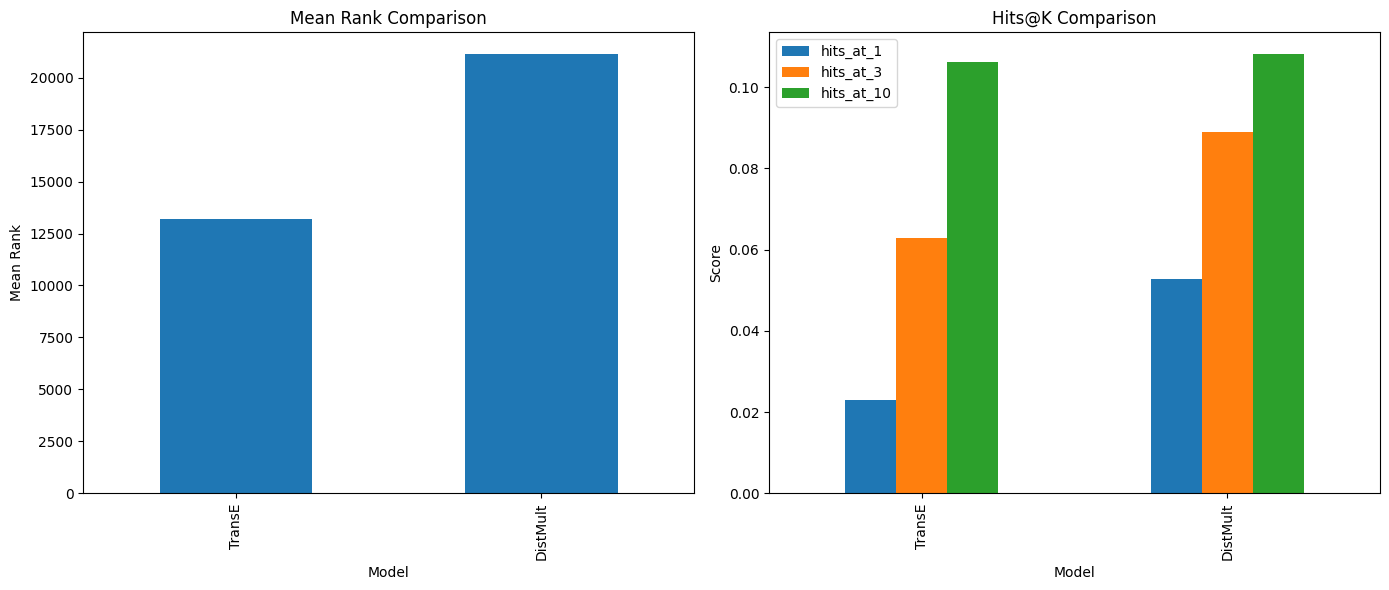

In [13]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot Rank-Based Metrics
comparison_df[['mean_rank']].plot(kind='bar', ax=axes[0], legend=False, color=['#1f77b4'])
axes[0].set_title('Mean Rank Comparison')
axes[0].set_ylabel('Mean Rank')
axes[0].set_xlabel('Model')

# Plot Hits@K Metrics
comparison_df[['hits_at_1', 'hits_at_3', 'hits_at_10']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Hits@K Comparison')
axes[1].set_ylabel('Score')
axes[1].set_xlabel('Model')

# Adjust layout
plt.tight_layout()

# Save and show the figure
plt.savefig('output/visualization/embedding_model_comparison.png')
plt.show()


## 5. Entity Similarity Analysis

Let's find similar entities based on our learned embeddings.

In [14]:
# Get a few sample entities
sample_entity_uris = []
sample_entity_texts = []

# First, get all entities with their labels
entity_labels = {}
from rdflib.namespace import RDFS
for s, p, o in augmenter.graph.triples((None, RDFS.label, None)):
    entity_labels[str(s)] = str(o)

# Choose a few sample entities of different types
person_entities = []
org_entities = []
loc_entities = []

for entity_uri, entity_type in entities:
    if entity_uri in entity_labels:
        if entity_type == 'PERSON' and len(person_entities) < 3:
            person_entities.append((entity_uri, entity_labels[entity_uri]))
        elif entity_type == 'ORG' and len(org_entities) < 3:
            org_entities.append((entity_uri, entity_labels[entity_uri]))
        elif entity_type in ('GPE', 'LOC') and len(loc_entities) < 3:
            loc_entities.append((entity_uri, entity_labels[entity_uri]))
    
    if len(person_entities) >= 3 and len(org_entities) >= 3 and len(loc_entities) >= 3:
        break

# Combine all sample entities
sample_entities = person_entities + org_entities + loc_entities

# Print sample entities
print("Sample entities for similarity analysis:")
for entity_uri, entity_text in sample_entities:
    print(f"- {entity_text} ({entity_uri})")

Sample entities for similarity analysis:
- 18A (http://example.org/graphify/person/18A)
- Ablin (http://example.org/graphify/person/Ablin)
- Adam Hetts (http://example.org/graphify/person/Adam_Hetts)
- 12B debt Representatives (http://example.org/graphify/org/12B_debt_Representatives)
- 18A (http://example.org/graphify/org/18A)
- 18A AMD (http://example.org/graphify/org/18A_AMD)
- 4G (http://example.org/graphify/gpe/4G)
- AI (http://example.org/graphify/gpe/AI)
- AJ Bell (http://example.org/graphify/gpe/AJ_Bell)


In [15]:
# Find similar entities using TransE embeddings
print("Similar entities using TransE embeddings:")
for entity_uri, entity_text in sample_entities:
    print(f"\nEntities similar to '{entity_text}':")
    similar_entities = embedder.find_similar_entities(entity_uri, 'TransE', top_k=5)
    for similar_uri, similarity in similar_entities:
        print(f"- {similar_uri} (Similarity: {similarity:.4f})")

Similar entities using TransE embeddings:

Entities similar to '18A':
- http://example.org/graphify/org/18A (Similarity: 0.7299)
- http://en.wikipedia.org/wiki/18A (Similarity: 0.6152)
- http://dbpedia.org/resource/Rigid_frame (Similarity: 0.5765)
- http://example.org/graphify/org/Federal_Open_Market_Committee (Similarity: 0.5414)
- http://example.org/graphify/person/Lee_Taehwan (Similarity: 0.5374)

Entities similar to 'Ablin':
- http://en.wikipedia.org/wiki/Ablin?oldid=1003000302&ns=0 (Similarity: 0.6219)
- http://en.wikipedia.org/wiki/Ablin (Similarity: 0.5631)
- http://dbpedia.org/resource/Ashfield,_New_South_Wales (Similarity: 0.5569)
- http://dbpedia.org/resource/G._Mennen_Williams (Similarity: 0.5567)
- http://commons.wikimedia.org/wiki/Special:FilePath/Robert_Tappan_Morris.jpg (Similarity: 0.5471)

Entities similar to 'Adam Hetts':


2025-03-29 20:13:45,877 - src.knowledge_graph.embeddings - ERROR - Entity http://example.org/graphify/person/Adam_Hetts not found in knowledge graph
2025-03-29 20:13:45,877 - src.knowledge_graph.embeddings - ERROR - Entity http://example.org/graphify/org/12B_debt_Representatives not found in knowledge graph
2025-03-29 20:13:45,892 - src.knowledge_graph.embeddings - ERROR - Entity http://example.org/graphify/org/18A_AMD not found in knowledge graph
2025-03-29 20:13:45,892 - src.knowledge_graph.embeddings - ERROR - Entity http://example.org/graphify/gpe/4G not found in knowledge graph
2025-03-29 20:13:45,892 - src.knowledge_graph.embeddings - ERROR - Entity http://example.org/graphify/gpe/AI not found in knowledge graph
2025-03-29 20:13:45,892 - src.knowledge_graph.embeddings - ERROR - Entity http://example.org/graphify/gpe/AJ_Bell not found in knowledge graph



Entities similar to '12B debt Representatives':

Entities similar to '18A':
- http://example.org/graphify/person/18A (Similarity: 0.7299)
- http://example.org/graphify/org/Volvo (Similarity: 0.6221)
- http://dbpedia.org/resource/Bond (Similarity: 0.5485)
- http://example.org/graphify/entity/Texas_A&M_Aggies (Similarity: 0.5196)
- http://example.org/graphify/org/Big_Tech (Similarity: 0.5120)

Entities similar to '18A AMD':

Entities similar to '4G':

Entities similar to 'AI':

Entities similar to 'AJ Bell':


In [16]:
# Find similar entities using DistMult embeddings
print("Similar entities using DistMult embeddings:")
for entity_uri, entity_text in sample_entities[:3]:  # Just show a few for brevity
    print(f"\nEntities similar to '{entity_text}':")
    similar_entities = embedder.find_similar_entities(entity_uri, 'DistMult', top_k=5)
    for similar_uri, similarity in similar_entities:
        print(f"- {similar_uri} (Similarity: {similarity:.4f})")

Similar entities using DistMult embeddings:

2025-03-29 20:13:46,094 - src.knowledge_graph.embeddings - ERROR - Entity http://example.org/graphify/person/Adam_Hetts not found in knowledge graph




Entities similar to '18A':
- http://example.org/graphify/entity/18A (Similarity: 0.9620)
- http://example.org/graphify/org/18A (Similarity: 0.8993)
- http://example.org/graphify/entity/18A.jpg (Similarity: 0.8818)
- http://example.org/graphify/entity/Ginza_area_at_dusk_from_Tokyo_Tower.jpg (Similarity: 0.5834)
- http://commons.wikimedia.org/wiki/Special:FilePath/Seal_of_the_Assembly_of_the_State_of_California.svg (Similarity: 0.5347)

Entities similar to 'Ablin':
- http://example.org/graphify/entity/Ablin (Similarity: 0.9795)
- http://example.org/graphify/entity/Camfranglais (Similarity: 0.5510)
- http://example.org/graphify/entity/Melchiorhofmann.jpg (Similarity: 0.5235)
- http://dbpedia.org/resource/Strathfield,_New_South_Wales (Similarity: 0.5160)
- http://example.org/graphify/entity/Bill_Cole_(Montana_politician) (Similarity: 0.5159)

Entities similar to 'Adam Hetts':


## 6. Link Prediction

Now, let's test the link prediction capabilities of our embedding models.

In [17]:
# Get some relations from the knowledge graph
relations = set()
for s, p, o in augmenter.graph:
    if p != RDF.type and p != RDFS.label:
        relations.add(str(p))

# Choose a few sample relations
sample_relations = list(relations)[:5] if len(relations) >= 5 else list(relations)

print("Sample relations for link prediction:")
for relation in sample_relations:
    print(f"- {relation}")

Sample relations for link prediction:
- http://example.org/graphify/predicate/parts
- http://dbpedia.org/property/code
- http://example.org/graphify/predicate/keypeople
- http://dbpedia.org/property/influencedBy
- http://example.org/graphify/predicate/risk_between


In [18]:
# Find entity pairs for chosen relations
relation_triples = []

for relation in sample_relations:
    # Find triples with this relation
    relation_uri = relation
    for s, p, o in augmenter.graph.triples((None, URIRef(relation_uri), None)):
        # Check if subject and object entities exist in embedder
        if str(s) in embedder.entity_to_id and str(o) in embedder.entity_to_id:
            # Get entity labels
            s_label = entity_labels.get(str(s), str(s).split('/')[-1])
            o_label = entity_labels.get(str(o), str(o).split('/')[-1])
            
            relation_triples.append((str(s), s_label, relation_uri, str(o), o_label))
            break  # Just take one example per relation

print("Sample triples for link prediction:")
for s, s_label, p, o, o_label in relation_triples:
    p_short = p.split('/')[-1]
    print(f"- {s_label} --[{p_short}]--> {o_label}")

Sample triples for link prediction:
- Toronto --[parts]--> Scarborough, Toronto
- Cambridge University Press --[keypeople]--> Stephen Toope
- Reuters --[risk_between]--> mid-July


In [19]:
# Predict tail entities
print("Predicting tail entities with TransE:")
for s, s_label, p, o, o_label in relation_triples:
    p_short = p.split('/')[-1]
    print(f"\nGiven head '{s_label}' and relation '{p_short}', predicted tails:")
    predicted_tails = embedder.predict_tail_entities(s, p, 'TransE', top_k=5)
    for tail_uri, score in predicted_tails:
        print(f"- {tail_uri} (Score: {score:.4f})")
    
    # Check if the actual tail is in the predictions
    predicted_uris = [uri for uri, _ in predicted_tails]
    if o in predicted_uris:
        print(f"✓ Actual tail '{o_label}' is in the predictions at rank {predicted_uris.index(o) + 1}")
    else:
        print(f"✗ Actual tail '{o_label}' is not in the top 5 predictions")

Predicting tail entities with TransE:

2025-03-29 20:13:47,044 - src.knowledge_graph.embeddings - ERROR - Error predicting tail entities: Model.predict() missing 2 required positional arguments: 'hrt_batch' and 'target'
2025-03-29 20:13:47,044 - src.knowledge_graph.embeddings - ERROR - Error predicting tail entities: Model.predict() missing 2 required positional arguments: 'hrt_batch' and 'target'
2025-03-29 20:13:47,044 - src.knowledge_graph.embeddings - ERROR - Error predicting tail entities: Model.predict() missing 2 required positional arguments: 'hrt_batch' and 'target'




Given head 'Toronto' and relation 'parts', predicted tails:
✗ Actual tail 'Scarborough, Toronto' is not in the top 5 predictions

Given head 'Cambridge University Press' and relation 'keypeople', predicted tails:
✗ Actual tail 'Stephen Toope' is not in the top 5 predictions

Given head 'Reuters' and relation 'risk_between', predicted tails:
✗ Actual tail 'mid-July' is not in the top 5 predictions


In [20]:
# Predict head entities
print("Predicting head entities with DistMult:")
for s, s_label, p, o, o_label in relation_triples:
    p_short = p.split('/')[-1]
    print(f"\nGiven relation '{p_short}' and tail '{o_label}', predicted heads:")
    predicted_heads = embedder.predict_head_entities(p, o, 'DistMult', top_k=5)
    for head_uri, score in predicted_heads:
        print(f"- {head_uri} (Score: {score:.4f})")
    
    # Check if the actual head is in the predictions
    predicted_uris = [uri for uri, _ in predicted_heads]
    if s in predicted_uris:
        print(f"✓ Actual head '{s_label}' is in the predictions at rank {predicted_uris.index(s) + 1}")
    else:
        print(f"✗ Actual head '{s_label}' is not in the top 5 predictions")

2025-03-29 20:13:47,224 - src.knowledge_graph.embeddings - ERROR - Error predicting head entities: name 'inspect' is not defined


Predicting head entities with DistMult:

Given relation 'parts' and tail 'Scarborough, Toronto', predicted heads:
✗ Actual head 'Toronto' is not in the top 5 predictions

Given relation 'keypeople' and tail 'Stephen Toope', predicted heads:


2025-03-29 20:13:47,231 - src.knowledge_graph.embeddings - ERROR - Error predicting head entities: name 'inspect' is not defined
2025-03-29 20:13:47,231 - src.knowledge_graph.embeddings - ERROR - Error predicting head entities: name 'inspect' is not defined


✗ Actual head 'Cambridge University Press' is not in the top 5 predictions

Given relation 'risk_between' and tail 'mid-July', predicted heads:
✗ Actual head 'Reuters' is not in the top 5 predictions


## 7. Visualization of Embeddings

Let's visualize the entity embeddings to see how they cluster.

2025-03-29 20:13:48,113 - src.knowledge_graph.embeddings - INFO - Applying t-SNE dimensionality reduction...
2025-03-29 20:13:50,224 - src.knowledge_graph.embeddings - INFO - Visualization saved to output/visualization/transe_embeddings.png


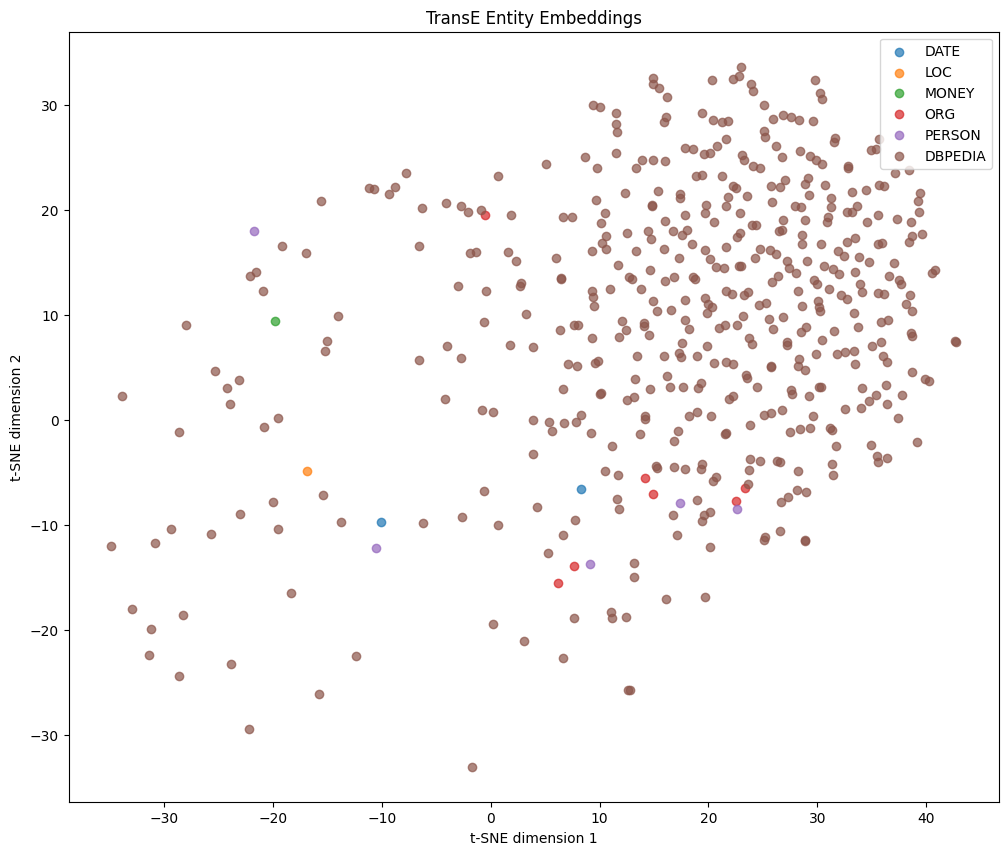

True

In [21]:
# Group entities by type for visualization
entity_type_triples = []
for s, p, o in augmenter.graph.triples((None, RDF.type, None)):
    entity_type_triples.append((str(s), 'rdf:type', str(o)))

# Create entity type mappings for visualization
entity_types = embedder.group_entities_by_type(entity_type_triples)

# Visualize TransE embeddings
embedder.visualize_embeddings(
    model_name='TransE',
    entity_types=entity_types,
    sample_size=1000,  # Limit for better visualization
    figsize=(12, 10),
    output_path='output/visualization/transe_embeddings.png',
    title='TransE Entity Embeddings'
)

2025-03-29 20:13:51,300 - src.knowledge_graph.embeddings - INFO - Applying t-SNE dimensionality reduction...
2025-03-29 20:13:53,335 - src.knowledge_graph.embeddings - INFO - Visualization saved to output/visualization/distmult_embeddings.png


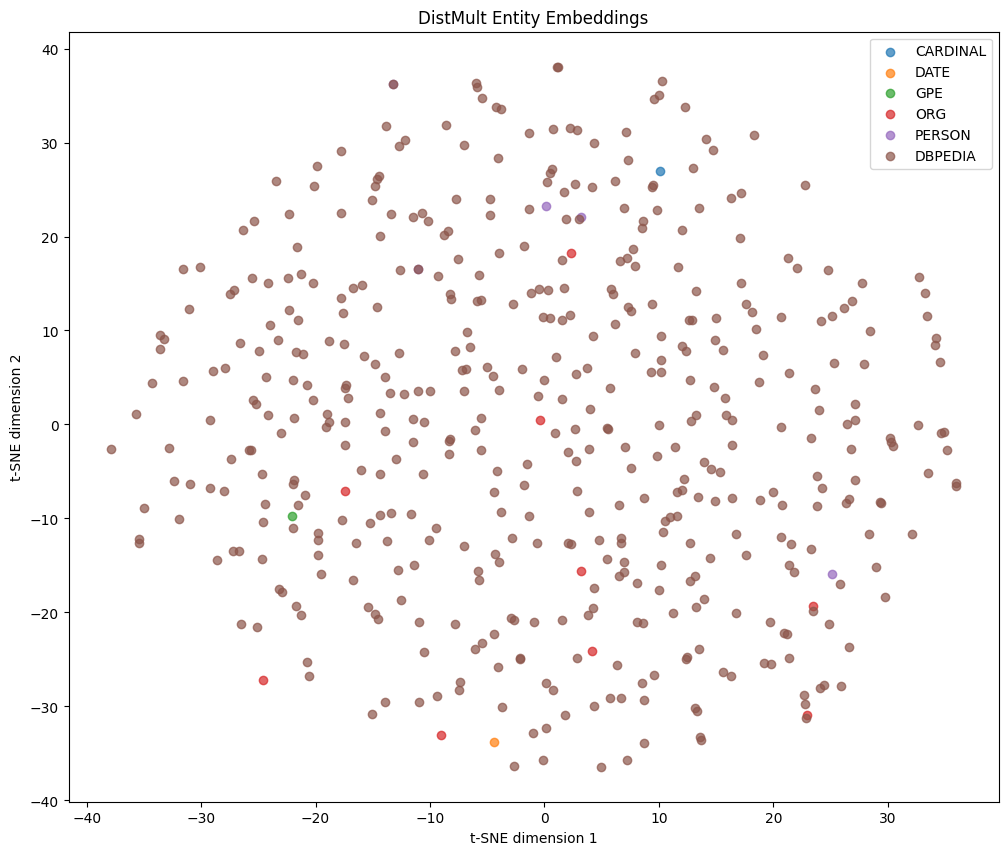

True

In [22]:
# Visualize DistMult embeddings
embedder.visualize_embeddings(
    model_name='DistMult',
    entity_types=entity_types,
    sample_size=1000,  # Limit for better visualization
    figsize=(12, 10),
    output_path='output/visualization/distmult_embeddings.png',
    title='DistMult Entity Embeddings'
)

## 8. Save Models and Embeddings

Finally, let's save our models and embeddings for future use.

In [23]:
# Save models
models_dir = 'output/models'
os.makedirs(models_dir, exist_ok=True)

for model_name in ['TransE', 'DistMult']:
    embedder.save_model(model_name, models_dir)

# Save entity and relation embeddings as NumPy arrays
embeddings_dir = 'output/embeddings'
os.makedirs(embeddings_dir, exist_ok=True)

for model_name in ['TransE', 'DistMult']:
    # Get embeddings
    entity_embeddings = embedder.get_entity_embeddings(model_name)
    relation_embeddings = embedder.get_relation_embeddings(model_name)
    
    # Save embeddings
    np.save(os.path.join(embeddings_dir, f"{model_name}_entity_embeddings.npy"), entity_embeddings)
    np.save(os.path.join(embeddings_dir, f"{model_name}_relation_embeddings.npy"), relation_embeddings)
    
    print(f"Saved {model_name} embeddings:")
    print(f"- Entity embeddings: {entity_embeddings.shape}")
    print(f"- Relation embeddings: {relation_embeddings.shape}")

# Save entity and relation mappings as JSON
mappings = {
    'entity_to_id': {k: v for k, v in embedder.entity_to_id.items()},
    'relation_to_id': {k: v for k, v in embedder.relation_to_id.items()},
    'id_to_entity': {str(k): v for k, v in embedder.id_to_entity.items()},
    'id_to_relation': {str(k): v for k, v in embedder.id_to_relation.items()}
}

with open(os.path.join(embeddings_dir, 'mappings.json'), 'w') as f:
    json.dump(mappings, f, indent=2)

print("Saved entity and relation mappings")

2025-03-29 20:13:53,766 - src.knowledge_graph.embeddings - INFO - Model TransE saved to output/models\TransE_model.pkl
2025-03-29 20:13:53,849 - src.knowledge_graph.embeddings - INFO - Model DistMult saved to output/models\DistMult_model.pkl


Saved TransE embeddings:
- Entity embeddings: (50905, 50)
- Relation embeddings: (1362, 50)
Saved DistMult embeddings:
- Entity embeddings: (50905, 50)
- Relation embeddings: (1362, 50)
Saved entity and relation mappings
